## Building a model by including all Xs and then removing them until you have the "best set"

Lasso - a modified regression

RFECV - Recursive Feature Elimination

Boosting

In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import RFECV

In [ ]:
# DL data
url = 'https://github.com/LeDataSciFi/lectures-spr2020/blob/master/assignment_data/Fannie_Mae_Plus_Data.gzip?raw=true'
fannie_mae = pd.read_csv(url,compression='gzip') 

# separate out y var
y = fannie_mae['Original_Interest_Rate']
fannie_mae.drop('Original_Interest_Rate',axis=1,inplace=True)

In [ ]:
######## repeat processing set up from last lecture, with more variables

# how to process two types of vars
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore',sparse=False))])

# put vars into those two types - many vars are missing
num_features = ['Original_UPB', 'Original_Loan_Term','Original_Debt_to_Income_Ratio', 
               'UNRATE', 'CPIAUCSL', 
               'rGDP', 'TCMR', 'POILWTIUSDM', 'TTLCONS', 'DEXUSEU', 'BOPGSTB',
               'GOLDAMGBD228NLBM', 'CSUSHPISA', 'MSPUS']
cat_features = ['Property_type', 'Loan_purpose','Product_type','First_time_home_buyer_indicator',
               'Property_state','Origination_Channel']

# set up the the preprocessor (num_features is new now)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])


## Option 1 - lasso

$sum(y- y_pred)**2) + alpha * sum(|coefficients |) $

Lasso takes all X vars and puts 0 coefs on "unimportant" variables.

The key parameter is alpha. When alpha is 0, the estimator minimizes the squared residuals in a regression, which is just normal regression. As alpha goes up, there is an increasing emphasis on reducing the regression coefficients to zero. 


In [ ]:
# split the data - only one fold for now...
X_train, X_test, y_train, y_test = train_test_split(fannie_mae, y, random_state=0,
                                  train_size=0.8)


In [ ]:
# lets run LASSO on this (sans pipeline)
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=.3) 
lasso.fit(preprocessor.fit_transform(X_train),y_train)
lasso.coef_ 


In [ ]:
# what's the right alpha - you could maximize OOS r2 via CV

preprocessor.fit(X_train)
reg2 = LassoCV().fit(preprocessor.transform(X_train),y_train)
print(reg2.score(preprocessor.transform(X_test),y_test))
print(reg2.alpha_)
reg2.coef_.round(2)


## Option 2 - RFECV

In [ ]:
selector = RFECV(LinearRegression(),step=1,cv=5)

# fill in missing values - the rfecv won't work otherwise
num_rfecvready = num_transformer.fit_transform(fannie_mae[num_features])

selector.fit(num_rfecvready,y)


In [ ]:
print('Which features does it select?')
print(fannie_mae[num_features].columns[selector.support_])

print('How does it rank the features?')
print(selector.ranking_)

## Option 3 for starting with all X and reducing the list - Gradient Boosting


https://www.kaggle.com/kashnitsky/topic-10-gradient-boosting

> Almost everyone in machine learning has heard about gradient boosting. Many data scientists include this algorithm in their data scientist's toolbox because of the good results it yields on any given (unknown) problem.
>
> **Furthermore, [Gradient Boosting/] XGBoost is often the standard recipe for winning ML competitions.** It is so popular that the idea of stacking XGBoosts has become a meme. Moreover, boosting is an important component in many recommender systems; sometimes, it is even considered a brand. Let's look at the history and development of boosting.

https://scikit-learn.org/stable/datasets/index.html#boston-dataset

https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html?highlight=boosted




In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

# #############################################################################
# Load data
boston = datasets.load_boston()
X, y = shuffle(boston.data, boston.target, random_state=13)
X = X.astype(np.float32)
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

In [2]:
# #############################################################################
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

In [3]:
clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

MSE: 6.3656


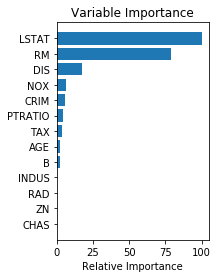

In [7]:
feature_importance = clf.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())

# bar plot those
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()